 Description
This is the analysis of the chlorophyll fluorometer by taking measurements 
of chlorophyll standards via rhodamine dye. This analysis is to test the fluorometer's measurement sensitivity using serial dilutions of rhodamine dye.

# Fluorometer Testing

## Fluorometer Design    
This fluorometer is a benchtop model with housing which positions the LED and 
the AS7341 at a 90 degree angle as well as will be an opaque design as to 
eliminate any ambient light from impacting the measurements. The top of the benchtop design contains a hole 
which fits a cuvette. A cuvette is placed into the fluorometer with the water
sample to begin testing. Design materials an be found at:
https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Hardware/Cuvette%20Holder%20Updated%20Optics. 

# Methods
These methods for dilutions can be found at: https://github.com/COAST-Lab/Chlorophyll-Fluorometer-/blob/main/Data%20Analysis/AS7341%20Dilution%20Tests/AS7341_Dilutions_Methods.ipynb

# Data
Data for this test can be found at: https://github.com/jessiewynne/Chlorophyll-Fluorometer-/tree/main/Data%20Analysis/AS7341%20Dilution%20Tests/AS7341%20Dilutions%202_8_24

# Analysis 
This is the code for the dilution test of the AS7341 device on 2/8/24

# Cuvette Test with no movement
### Import modules and file paths. Define catagories and create dictionaries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, t
from sklearn.metrics import r2_score, mean_squared_error

# Replace with the actual file path
file_path = "/Users/jessiewynne/chla_fluorometer/AS7341 Dilutions 2.8.24/2_8_24_700ms_256x_through_hole_dilutions.csv"
# Read the CSV file without skipping any rows

df = pd.read_csv(file_path, encoding='utf-8')

# Filter out rows where the 'Test' column is 'test'
df = df[df['Test'].str.lower() != 'test'] 

# Convert 'F8 (Raw)' column to numeric values
df['F8 (Raw)'] = pd.to_numeric(df['F8 (Raw)'], errors='coerce')

# Get unique test categories (dilution values) in the order of appearance
categories = df['Test'].unique()

# Create a dictionary to store the 'F8 (Raw)' values for each category (dilution)
category_f8_raw_dict = {}

# Create dictionaries to store confidence intervals and ranges of uncertainty
confidence_intervals = {}
uncertainty_ranges = {}
lobs = {}  # To store LoB values
lods = {}  # To store LoD values

# Initialize mean_blank before the loop
mean_blank = 0.0

# Store unique x-values and their corresponding data points
x_values = []
y_values = []
std_devs = []

### Complete Calculations for the F8 values 

In [2]:
for category in categories:
    # Exclude the first data point from each category
    category_df = df[df['Test'] == category][1:]
    category_f8_raw_dict[category] = category_df['F8 (Raw)']

    # Calculate the mean and standard deviation for 'F8 (Raw)' data in each category
    category_f8_raw_mean = category_df['F8 (Raw)'].mean()
    category_f8_raw_std = category_df['F8 (Raw)'].std()
    # print(category_f8_raw_mean)

    # Calculate the sample size for each category
    category_sample_size = len(category_df['F8 (Raw)'])

    # Calculate the standard error for each category's mean
    category_standard_error = category_f8_raw_std / np.sqrt(category_sample_size)

    # Define the confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the margin of error using the t-distribution
    margin_of_error = t.ppf((1 + confidence_level) / 2, category_sample_size - 1) * category_standard_error

    # Calculate the confidence interval for each category's mean
    confidence_interval = (category_f8_raw_mean - margin_of_error, category_f8_raw_mean + margin_of_error)

    # Calculate the range of uncertainty (95% CI width) for each category
    uncertainty_range = confidence_interval[1] - confidence_interval[0]

    # Check if the 'Test' value can be converted to a float, otherwise, skip it
    try:
        x_value = float(category)
        x_values.append(x_value)
        y_values.append(category_f8_raw_mean)
        std_devs.append(category_f8_raw_std)
    except ValueError:
        pass

# Exclude the first data point from each trial
df_no_first = df.groupby('Test').apply(lambda group: group.iloc[1:])

# Calculate the mean and standard deviation for the entire dataset for 'F8 (Raw)' data
dataset_f8_raw_mean = df['F8 (Raw)'].mean()
dataset_f8_raw_std = df['F8 (Raw)'].std()
print(dataset_f8_raw_mean)
print(dataset_f8_raw_std)

# Calculate Coefficient of Variation for all 'F8 (Raw)' values together
all_cv = (dataset_f8_raw_std/dataset_f8_raw_mean)

# Calculate the sample size for the entire dataset
dataset_sample_size = len(df['F8 (Raw)'])

# Calculate the standard error for the entire dataset's mean
dataset_standard_error = dataset_f8_raw_std / np.sqrt(dataset_sample_size)

# Calculate the margin of error using the t-distribution
confidence_level = 0.95
margin_of_error = t.ppf((1 + confidence_level) / 2, dataset_sample_size - 1) * dataset_standard_error

# Calculate the confidence interval for the entire dataset's mean
confidence_interval = (dataset_f8_raw_mean - margin_of_error, dataset_f8_raw_mean + margin_of_error)

# Calculate the range of uncertainty (95% CI width) for the entire dataset
uncertainty_range = confidence_interval[1] - confidence_interval[0]

# Calculate the minimum and maximum 'F8 (Raw)' values for each test category
min_f8_values = {}
max_f8_values = {}
for category, f8_raw_values in category_f8_raw_dict.items():
    min_f8_values[category] = f8_raw_values.min()
    max_f8_values[category] = f8_raw_values.max()

25.318840579710145
13.666673736300751


### Create a scatter plot

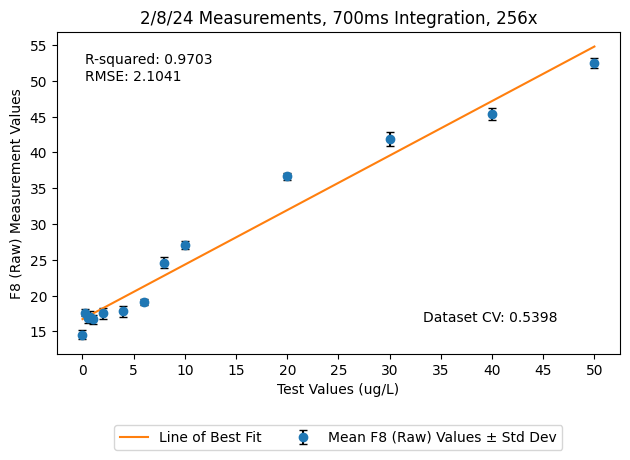

In [3]:
# Scatter plot for mean F8 values with error bars and legend
plt.errorbar(x_values, y_values, yerr=std_devs, fmt='o', capsize=3, ecolor='black', label='Mean F8 (Raw) Values ± Std Dev')

# Calculate the line of best fit parameters (slope and intercept)
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Create a function to calculate predicted values using the line of best fit equation
def predict_values(x, slope, intercept):
    return slope * x + intercept

# Plot the line of best fit
plt.plot(x_values, predict_values(np.array(x_values), slope, intercept), label='Line of Best Fit')

# Calculate R-squared and RMSE
y_predicted = predict_values(np.array(x_values), slope, intercept)
r_squared = r2_score(y_values, y_predicted)
rmse = np.sqrt(mean_squared_error(y_values, y_predicted))

# Set x-axis tick positions at intervals of 5
plt.xticks(np.arange(min(x_values), max(x_values)+1, 5))

plt.xlabel('Test Values (ug/L)')
plt.ylabel('F8 (Raw) Measurement Values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Move legend down and adjust layout
# plt.title("AS7341 Dilutions 256x Gain, 700ms Integration")
plt.title("2/8/24 Measurements, 700ms Integration, 256x")

# Display R-squared and RMSE on the plot
plt.annotate(f'R-squared: {r_squared:.4f}\nRMSE: {rmse:.4f}', xy=(0.05, 0.85), xycoords='axes fraction')
# Display dataset Coefficient of Variation on the plot
plt.annotate(f'Dataset CV: {all_cv:.4f}', xy=(0.65, 0.1), xycoords='axes fraction', fontsize=10)

plt.tight_layout()